# Image Captioning

**Computer Vision and Natural Language Processing for Automatic Image Captioning**

Matheus Schmitz

<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a>

<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>

**Data Sources:**

Flickr 8K - 
https://forms.illinois.edu/sec/1713398

GloVe - 
https://nlp.stanford.edu/projects/glove/

In [1]:
PATH_IMAGES = 'Flickr_8K/Images/'

## Google Colab

In [2]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Image_Captioning/")

Mounted at /content/drive


## Packages

In [3]:
# Py Data Stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP
import re

# Computer Vision
import cv2

# Tensorflow & Keras
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Others
import pickle
import collections
from random import shuffle
from tqdm import tqdm

# Get rid of warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [4]:
# Read the captions from  Flickr_8K/captions.txt
df_captions = pd.read_csv('Flickr_8K/captions.txt', sep=',')
print(f'df_captions.shape: {df_captions.shape}')

# Set the image name as index
df_captions.set_index('image', inplace=True)
df_captions.tail(3)

df_captions.shape: (40455, 2)


,caption
image,
997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
997722733_0cb5439472.jpg,A rock climber in a red shirt .
997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wa...


In [5]:
# Seems like there are multiple alternative captions per image...
SAMPLE_IMAGE = df_captions.sample(1).index[0]
df_captions[df_captions.index == SAMPLE_IMAGE]

,caption
image,
3211316116_a2462e327d.jpg,A man in a yellow shirt surfing .
3211316116_a2462e327d.jpg,A surfer in a yellow shirt is riding a wave th...
3211316116_a2462e327d.jpg,A surfer is riding on a breaking wave .
3211316116_a2462e327d.jpg,Surfer surfs ahead of a crashing wave
3211316116_a2462e327d.jpg,The man is riding a large wave on a surfboard .


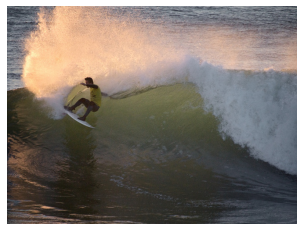

Captions:
A man in a yellow shirt surfing .
A surfer in a yellow shirt is riding a wave that is reflecting sunlight .
A surfer is riding on a breaking wave .
Surfer surfs ahead of a crashing wave
The man is riding a large wave on a surfboard .


In [6]:
# Plot an (IMAGE, CAPTIONS) pair
img = cv2.imread(PATH_IMAGES + SAMPLE_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

print('Captions:')
for caption in df_captions[df_captions.index == SAMPLE_IMAGE]['caption']:
    print(caption)

> The legends need some cleaning as they have some captilized letters as well as dots (.) at the end and might have other issues such as special characters.

## Downsample

In [7]:
DOWNSAMPLE = False
FRACTION = 0.05

if DOWNSAMPLE:
    all_imgs = df_captions.groupby('image').groups.keys()
    sampled_imgs = pd.DataFrame(all_imgs).sample(frac=FRACTION).values.flatten()
    df_captions = df_captions[df_captions.index.isin(sampled_imgs)]
    print(f'df_captions.shape: {df_captions.shape}')

SAMPLE_IMAGE = df_captions.sample(1).index[0]

## Train-Test Split

In [8]:
# 80/20 split
idx_train, idx_test = train_test_split(df_captions.index, test_size=0.3)
idx_test, idx_valid = train_test_split(idx_test, test_size=0.5)
print(f'Train set size: {len(idx_train)}')
print(f'Valid set size: {len(idx_valid)}')
print(f'Test set size: {len(idx_test)}')

Train set size: 28318
Valid set size: 6069
Test set size: 6068


## Preprocessing Images

### Load Feature Extraction Layers from Xception

Xception: Deep Learning with Depthwise Separable Convolutions

https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf

In [9]:
# Load Xception model
XCEPTION = Xception(weights='imagenet', input_shape=(299, 299, 3))
XCEPTION.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [10]:
# Remove the model's head (two last layers), keeping only the feature extraction layers
FEATURE_EXTRACTOR = Model(XCEPTION.input, XCEPTION.layers[-2].output)
FEATURE_EXTRACTOR.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

### Preprocessing Images for Xception

In [11]:
def xception_preprocess(img):

    # Load the image
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)

    # Conver the tensor from 3D to 4D
    img = np.expand_dims(img, axis=0)

    # Preprocess with Xception's default preprocess funtion
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img.shape: (1, 299, 299, 3)


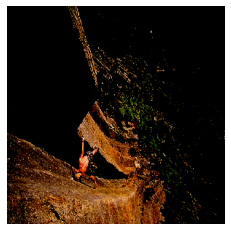

In [12]:
# Testing the proprocess function
img = xception_preprocess(PATH_IMAGES + SAMPLE_IMAGE)
print(f'img.shape: {img.shape}')
plt.imshow(img[0])
plt.axis('off')
plt.show()

> Seems like the normalization from preprocessing is making the images darker...

### Feature Extraction

In [13]:
def extract_img_features(img):
    img = xception_preprocess(img)
    feature_vector = FEATURE_EXTRACTOR.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [14]:
# Test the function
print(extract_img_features(PATH_IMAGES+SAMPLE_IMAGE)[:10])
print('Vector shape:', extract_img_features(PATH_IMAGES+SAMPLE_IMAGE).shape)

[0.12952198 0.12130713 0.05337065 0.01144827 0.         0.
 0.46221817 0.10061493 0.23429646 0.04971228]
Vector shape: (2048,)


In [15]:
# Extract features from images 
### CELL PROCESSING TIME IS ABOUT 1 HOUR IF NOT LOADING FROM DISK###
LOAD_FEATURES_FROM_DISK = True

if LOAD_FEATURES_FROM_DISK:
    
    try:
        with open('Flickr_8K/img_features_dict.pkl', 'rb') as file:
            img_features_dict = pickle.load(file)
        print('Loaded image features from disk.')
    
    except FileNotFoundError as fnf_error:
        print(fnf_error)
    
    except:
        print('Could not load image features from disk!')

else:
    print('Extracting image features from Xception.')
    print('Estimated processing time: 1 hour.')
    img_features_dict = {}

    # Loop through all images
    for img in tqdm(list(idx_train) + list(idx_valid) + list(idx_test)):
        try:
            img_features_dict[img] = extract_img_features(PATH_IMAGES + img)
        except:
            pass

    # Save result to disk
    with open('Flickr_8K/img_features_dict.pkl', 'wb') as file:
        pickle.dump(img_features_dict, file)

Loaded image features from disk.


## Preprocessing Captions

### Cleaning the Captions' Texts

In [16]:
# Function to clean data
def clean_caption(sentence):
    sentence = sentence.lower()

    # Change all non-characters to spaces
    sentence = re.sub("[^a-z]+", " ", sentence)

    # Only return the sentence if it's longer than 1 character
    if len(sentence) > 1:
        return sentence
    else:
        pass

In [17]:
# Test the function
clean_caption("BIG 123 foot ain't real '>.<" )

'big foot ain t real '

In [18]:
# Apply to all captions
df_captions['caption_clean'] = df_captions['caption'].map(clean_caption)
df_captions.head(3)

,caption,caption_clean
image,,
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a child in a pink dress is climbing up a set o...
1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a girl going into a wooden building
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,a little girl climbing into a wooden playhouse


In [19]:
# Check if we generated any NaN's
print('df_captions.shape:', df_captions.shape)
df_captions[df_captions.isnull().any(axis=1)]

df_captions.shape: (40455, 2)


,caption,caption_clean
image,,
2428275562_4bde2bc5ea.jpg,A,None
3640443200_b8066f37f6.jpg,a,None


In [20]:
# Keep only the non-NaN rows
df_captions = df_captions[~df_captions.isnull().any(axis=1)]
print('New shape: ', df_captions.shape)

New shape:  (40453, 2)


In [21]:
# Because there are duplicatei indexes, in order to save we first need to covert
# To a dictionary whose values are a list of alternative captions
img_captions = {}

for img, caption in df_captions.iterrows():

    # Initiate the dict elements for each image
    if img_captions.get(img) is None:
        img_captions[img] = []

    # Append all alternate image captions under the same image key
    img_captions[img].append(caption['caption_clean'])

# Check result
img_captions[SAMPLE_IMAGE]

['a boy does a cartwheel on a rock cliff ',
 'a man climbs a large rock ',
 'a man climbs on a steep structure ',
 'a man climbs up a cliff face with no safety equipment ',
 'a shirtless man is climbing up a mountainside ']

In [22]:
# Save to disk
with open('Flickr_8K/captions_clean.txt', 'w') as file:
    file.write(str(img_captions))

### Prepare Vocabulary

In [23]:
# Create a set to store the vocabulary
vocab = set()

# Then loop through the dict with images and captions and append to the vocab
for key, value in img_captions.items():
    [vocab.update(sentence.split()) for sentence in value]

# Unique words
print(f'Unique vocabulary words: {len(vocab)}')

# Total words
total_words = []
for key, value in img_captions.items():
    [total_words.append(word) for sentence in value for word in sentence.split()]
print(f'Total number of words: {len(total_words)}')

Unique vocabulary words: 8441
Total number of words: 437427


In [24]:
# Create a word counter
counter = collections.Counter(total_words)
counter.most_common(10)

[('a', 62990),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723)]

**Complete Vocabulary**

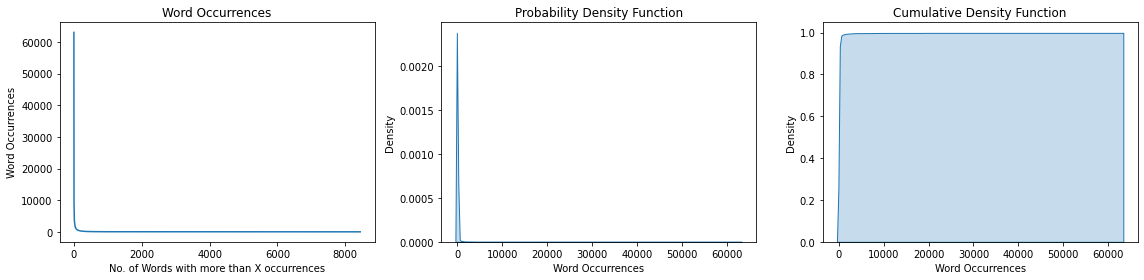

In [25]:
# Plot Word Occurrences
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=plt.figaspect(0.25))

fig.sca(axes[0])
plt.plot([x for x in sorted(counter.values(), reverse=True)])
plt.title('Word Occurrences')
plt.xlabel('No. of Words with more than X occurrences')
plt.ylabel('Word Occurrences')

fig.sca(axes[1])
sns.kdeplot([x for x in sorted(counter.values(), reverse=True)], shade=True, ax=axes[1])
plt.xlabel('Word Occurrences')
plt.title('Probability Density Function')

fig.sca(axes[2])
sns.kdeplot([x for x in sorted(counter.values(), reverse=True)], shade=True, cumulative=True, ax=axes[2])
plt.xlabel('Word Occurrences')
plt.title('Cumulative Density Function')

plt.tight_layout()

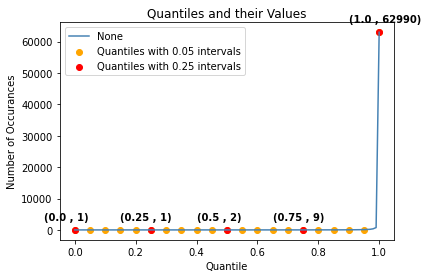

In [26]:
# Extracting the quantiles
quantiles = pd.Series(counter).quantile(np.arange(0, 1.01, 0.01), interpolation='higher')

# Plotting the quantils
quantiles.plot(kind='line', color='steelblue')

# Demark the quantiles in increments of 0.05 and 0.25
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='Quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='red', label='Quantiles with 0.25 intervals')

# Titles, labels, legend
plt.title('Quantiles and their Values')
plt.xlabel('Quantile')
plt.ylabel('Number of Occurances')
plt.legend(loc='best')

# Annotate the 0th, 25th, 50th, 75th and 100th percentiles
for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s=f'({x} , {y})', xy=(x,y), xytext=(x-0.1, y+max(quantiles.values)*0.05), fontweight='bold')

plt.show()

> This is peculiar... looks like over half of the words have two or less occurances...
>
> This doesn't bode well for the success of our classifier... 
>
> I'll try removing words under a certain threshold.

**Shrank Vocabulary**

In [27]:
# Convert the counter to a dictionary, so we can remove low frequency words
freq_cnt = dict(counter)

# Then sort the dictionary by word frequency
freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x: x[1])

# Define a threshold for cutting
THRESHOLD = quantiles[0.5] # Keeping only the 50% most frequent words

# Remove infrequent words
freq_cnt = [word_tuple for word_tuple in freq_cnt if word_tuple[1] > THRESHOLD]
vocab = set([word_tuple[0] for word_tuple in freq_cnt])
print(f'Unique vocabulary words: {len(vocab)}')

Unique vocabulary words: 4066


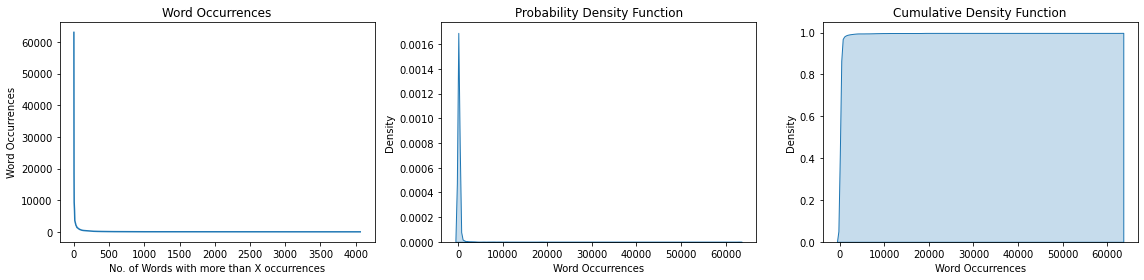

In [28]:
# Plot Word Occurrences
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=plt.figaspect(0.25))

fig.sca(axes[0])
plt.plot([x[1] for x in freq_cnt])
plt.title('Word Occurrences')
plt.xlabel('No. of Words with more than X occurrences')
plt.ylabel('Word Occurrences')

fig.sca(axes[1])
sns.kdeplot([x[1] for x in freq_cnt], shade=True, ax=axes[1])
plt.xlabel('Word Occurrences')
plt.title('Probability Density Function')

fig.sca(axes[2])
sns.kdeplot([x[1] for x in freq_cnt], shade=True, cumulative=True, ax=axes[2])
plt.xlabel('Word Occurrences')
plt.title('Cumulative Density Function')

plt.tight_layout()

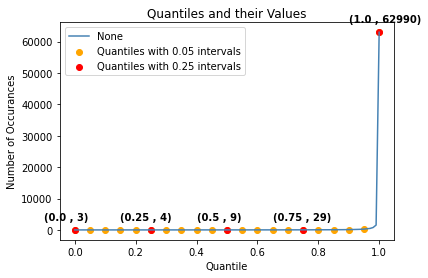

In [29]:
# Extracting the quantiles
quantiles = pd.Series([x[1] for x in freq_cnt]).quantile(np.arange(0, 1.01, 0.01), interpolation='higher')

# Plotting the quantils
quantiles.plot(kind='line', color='steelblue')

# Demark the quantiles in increments of 0.05 and 0.25
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='Quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='red', label='Quantiles with 0.25 intervals')

# Titles, labels, legend
plt.title('Quantiles and their Values')
plt.xlabel('Quantile')
plt.ylabel('Number of Occurances')
plt.legend(loc='best')

# Annotate the 0th, 25th, 50th, 75th and 100th percentiles
for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s=f'({x} , {y})', xy=(x,y), xytext=(x-0.1, y+max(quantiles.values)*0.05), fontweight='bold')

plt.show()

### Preparing Captions for Training

In [30]:
# Map words and indexes
word_to_index = {}
index_to_word = {}
for idx, word in enumerate(vocab):
    word_to_index[word] = idx
    index_to_word[idx] = word

# Add tokens for sequence start and end
word_to_index['<start>'] = len(vocab)
word_to_index['<end>'] = len(vocab) + 1
index_to_word[len(vocab)] = '<start>'
index_to_word[len(vocab) + 1] = '<end>'

In [31]:
# Define max caption lenght
max_len = 0
for key, value in img_captions.items():
    for caption in value:
        max_len = max(max_len, len(caption.split()))
print(f'Max caption lenght: {max_len}')

Max caption lenght: 36


In [32]:
# Demark the <start> and <end> of caption sequences

captions_train = {}
for img in idx_train:
    captions_train[img] = []
    for caption in img_captions[img]:
        formatted_caption = '<start> ' + caption + ' <end>'
        captions_train[img].append(formatted_caption)

captions_valid = {}
for img in idx_valid:
    captions_valid[img] = []
    for caption in img_captions[img]:
        formatted_caption = '<start> ' + caption + ' <end>'
        captions_valid[img].append(formatted_caption)

captions_test = {}
for img in idx_test:
    captions_test[img] = []
    for caption in img_captions[img]:
        formatted_caption = '<start> ' + caption + ' <end>'
        captions_test[img].append(formatted_caption)      

### Word Embeddings

Using pretrained word embeddings from Glove.

In [33]:
# Number of embedding dimensions to use {50, 100, 200 or 300}
EMBEDDING_DIM = 50

In [34]:
# Open the downloaded glove model
with open(f'glove.6B/glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf8') as GLOVE:

    # Map word to their Glove embeddings
    word_to_embedding = {}

    # Loop through the Glove txt file to get the desired word embeddings
    for line in GLOVE:

        # The line has 51 elements, the word followed by the 50 element long embedding
        values = line.split()

        # Extract the word
        word = values[0]

        # Extract the embeddng
        word_embedding = np.array(values[1:], dtype='float')

        # Map word to embedding
        word_to_embedding[word] = word_embedding

# Close the file
GLOVE.close()

In [35]:
# Testing the embedding
word_to_embedding['hippopotamus']

array([ 0.53226 , -0.3696  , -1.2322  , -0.58459 ,  0.29449 ,  1.2146  ,
        0.092114, -0.59669 , -0.15124 ,  0.21917 ,  0.50654 ,  0.043237,
        1.7278  ,  0.66534 ,  0.068886,  0.68044 ,  0.85844 ,  0.40637 ,
       -0.70629 ,  0.46653 , -0.96358 ,  0.069255, -0.22377 ,  0.12715 ,
        0.45017 ,  0.59522 , -0.41632 ,  0.72445 , -0.52813 , -0.32274 ,
       -0.32375 , -0.51735 ,  0.30444 ,  0.79503 ,  0.25015 ,  0.39791 ,
        0.57727 , -1.1384  ,  0.42985 , -0.26891 , -0.71918 , -0.076183,
        0.0923  ,  0.39775 ,  0.842   ,  0.17103 ,  0.20982 ,  0.15868 ,
        0.37548 , -0.76804 ])

In [36]:
# Updated vocabulary size
VOCAB_SIZE = len(word_to_index) + 1
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 4069


In [37]:
# Extract from Glove only the word vectors for the words in the used vocab
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Loop through the words in the word_to_index mapping
for word, idx in word_to_index.items():
    embedding_vector = word_to_embedding.get(word)

    # If the embedding_vector for the given word exists in glove, add it to the embedding_matrix
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

print(f'embedding_matrix.shape: {embedding_matrix.shape}')

embedding_matrix.shape: (4069, 50)


## Neural Network Architecture

**Image inputs**

In [38]:
# Receive the feature engineered images, which have shape (2048, )
layer_img_1 = Input(shape=(2048,))

# Dropout layer for regularization
layer_img_2 = Dropout(0.3)(layer_img_1)

# Dense layer to be trained
layer_img_3 = Dense(256, activation='relu')(layer_img_2)

**Text inputs**

In [39]:
# Receive the captions, with shape (max_len, 0)
layer_txt_1 = Input(shape=(max_len,))

# Embedding layer
layer_txt_2 = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(layer_txt_1)

# Dropout layer for regularization
layer_txt_3 = Dropout(0.3)(layer_txt_2)

# LSTM layer to be trained
layer_txt_4 = LSTM(256)(layer_txt_3)

**Decode inputs**

In [40]:
# Associate images with captions for the model to learn
decoder_1 = Add()([layer_img_3, layer_txt_4])

# Dense layer to be trained
decoder_2 = Dense(256, activation='relu')(decoder_1)

# Model output (softmax probabilities)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder_2)

**Model assembly**

In [41]:
model = Model(inputs = [layer_img_1, layer_txt_1],
              outputs = outputs )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 50)       203450      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

**Fix embedding layer weights (using Glove)**

In [42]:
# Set the embedding layer weights as those obtained from glove and disable training
model.layers[2].set_weights([embedding_matrix])
model.layers[2].treinable = False

**Compile model**

In [43]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Based on an inspectiong from training logs, maybe a larger learning rate could be used (0.003 instead of the default 0.001)
#optim = tensorflow.keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
#model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

## Data Loader

In [44]:
def data_loader(img_captions_dict, img_features, word_to_index, max_len, batch_size):

    # X1 = image input, X2 = caption input, y = label
    X1, X2, y = [], [], []

    # Counter
    n = 0

    # Infinite loop generator: as long as the NN asks for data we'll give it
    while True:

        # Shuffle the image_captions_dict before each iteration
        dict_as_list = list(img_captions_dict.items())
        shuffle(dict_as_list)
        img_captions_dict = dict(dict_as_list)

        # Extract image index and caption
        for img_idx, captions_list in img_captions_dict.items():

            n += 1

            # Extract the engineered features for the image
            try:
                xception_features = img_features[img_idx]
            except:
                continue
            
            # Loop though possible captions
            for caption in captions_list:

                # Convert words to indexes
                seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                # For each word in the caption
                for i in range(1,len(seq)): # start at 1 because of '<start>'

                    # Previously words in the sentence are used as prediction inputs
                    xi = seq[0:i]

                    # The current word has to be predicted
                    yi = seq[i]

                    # Pad xi with zeros
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]

                    # Convert the label word to categorical using one hot encoding
                    yi = to_categorical([yi], num_classes = VOCAB_SIZE)[0]

                    # Append the image and all it's captions to the lists
                    X1.append(xception_features)
                    X2.append(xi)
                    y.append(yi)

                    # Input to the NN based on batch size
                    if n == batch_size:
                        yield ([np.array(X1), np.array(X2)], np.array(y))

                        # And reset the lists
                        X1, X2, y = [], [], []
                        n = 0

## Train Model

In [45]:
# Hyperparameters
EPOCHS = 300 # Each epoch takes 75 seconds, estimated training time = 6 hours 15 minutes
BATCH_SIZE = 32
STEPS_TRAIN = len(captions_train) // BATCH_SIZE
STEPS_VALID = len(captions_valid) // BATCH_SIZE

In [46]:
# Data loaders
generator_train = data_loader(captions_train,
                              img_features_dict,
                              word_to_index,
                              max_len,
                              BATCH_SIZE)
generator_valid = data_loader(captions_valid,
                              img_features_dict,
                              word_to_index,
                              max_len,
                              BATCH_SIZE)

In [47]:
# Set to true to continue the model's training using the pre-trained neurons - THIS WILL GIVE AN ERROR IF THE WINDOW_SIZE OR NEURONS WAS CHANGED
# Set to false to train the neural network from scratch - THIS WILL LOSE ALL PROGRESS AND CAUSE WORSE PREDICTIONS
LOAD_TRAINED_WEIGHTS = True

if LOAD_TRAINED_WEIGHTS and os.path.exists('./callbacks/model.hdf5'):

    # Try loading weights. Will fail if the model structure changed
    try:

        # Load best model weights
        model.load_weights('./callbacks/model.hdf5')
  
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Based on an inspectiong from training logs, maybe a larger learning rate could be used (0.003 instead of the default 0.001)
        #optim = tensorflow.keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
        #model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

        # Check model
        model.summary()

        # Variable to guide the csv log callback
        SUCCESSFUL_WEIGHT_LOAD = True

    except:
        SUCCESSFUL_WEIGHT_LOAD = False
        print('Could not load weights. Most likely the network architecture changed.')

else:
    SUCCESSFUL_WEIGHT_LOAD = False
    if LOAD_TRAINED_WEIGHTS:
        print('Could not locate file with weights.')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 50)       203450      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [48]:
%%time

TRAIN_MODEL = True

if TRAIN_MODEL:

    # Define directory for model checkpoints
    CALLBACKS_DIR = './callbacks/'
    if not os.path.exists(CALLBACKS_DIR):
        os.mkdir(CALLBACKS_DIR)

    # Callbacks
    checkpoint = ModelCheckpoint(os.path.join(CALLBACKS_DIR, 'model.hdf5'), 
                                 monitor = 'loss',
                                 save_best_only = True,
                                 save_weights_only = True,
                                 verbose = 0)
    plateauLRreduce = ReduceLROnPlateau(factor = 0.5,
                                        patience = 10,
                                        monitor = 'val_loss',
                                        min_lr = 0.0000001,
                                        verbose = 1)
    stopearly = EarlyStopping(monitor = 'val_loss',
                              patience = 25,
                              verbose = 1)
    logCSV = CSVLogger(filename = os.path.join(CALLBACKS_DIR, 'log_model.csv'),
                       separator = ',', 
                       append = (LOAD_TRAINED_WEIGHTS & SUCCESSFUL_WEIGHT_LOAD)) 

    model_callbacks = [checkpoint, plateauLRreduce, stopearly, logCSV]

    # Train model and save history
    model_history = model.fit(generator_train,
                              validation_data = generator_valid,
                              epochs = EPOCHS,
                              steps_per_epoch = STEPS_TRAIN,
                              validation_steps = STEPS_VALID,
                              verbose = 1,
                              callbacks = model_callbacks,
                              use_multiprocessing=True,
                              workers = -1)
    
else:
    if SUCCESSFUL_WEIGHT_LOAD:
        print('Skipping model training. Using loaded weights without further training.')
    else:
        print('Skipping model training. Yet, could not load trained weights. THIS IS AN UNTRAINED MODEL UNSUITABLE FOR MAKING PREDICTIONS.')

Epoch 1/300
252/252 [==============================] - 70s 263ms/step - loss: 10.5670 - accuracy: 0.0363 - val_loss: 8.1366 - val_accuracy: 0.0713
Epoch 2/300
252/252 [==============================] - 65s 259ms/step - loss: 7.7451 - accuracy: 0.0874 - val_loss: 6.3860 - val_accuracy: 0.1919
Epoch 3/300
252/252 [==============================] - 65s 257ms/step - loss: 6.2514 - accuracy: 0.1890 - val_loss: 5.7967 - val_accuracy: 0.1987
Epoch 4/300
252/252 [==============================] - 64s 254ms/step - loss: 5.7769 - accuracy: 0.1958 - val_loss: 5.5307 - val_accuracy: 0.2027
Epoch 5/300
252/252 [==============================] - 64s 254ms/step - loss: 5.5270 - accuracy: 0.1996 - val_loss: 5.3579 - val_accuracy: 0.2049
Epoch 6/300
252/252 [==============================] - 65s 256ms/step - loss: 5.3674 - accuracy: 0.2023 - val_loss: 5.2329 - val_accuracy: 0.2083
Epoch 7/300
252/252 [==============================] - 64s 255ms/step - loss: 5.2531 - accuracy: 0.2043 - val_loss: 5.1218 

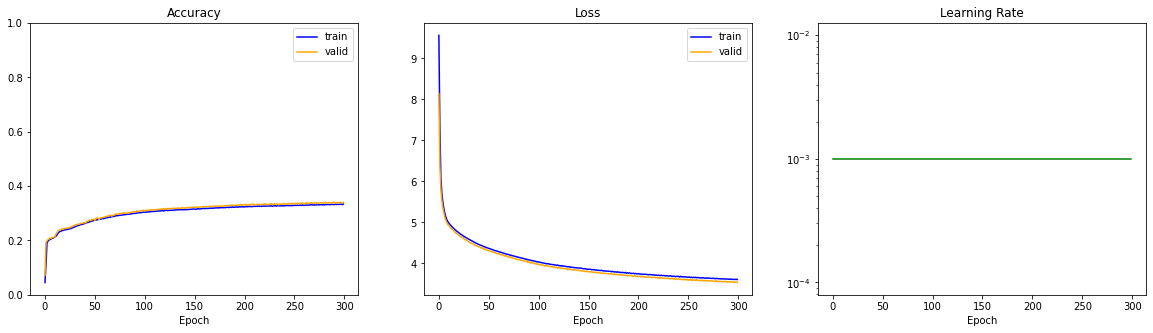

In [4]:
# Read the log file
log_model_1 = pd.read_csv('./callbacks/log_model.csv')

# Create figure
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Accuracy
fig.sca(axs[0])
plt.plot(log_model_1.index, log_model_1.accuracy, label='train', color='blue')
plt.plot(log_model_1.index, log_model_1.val_accuracy, label='valid', color='orange')
plt.legend()
axs[0].set_ylim([0, 1])
axs[0].title.set_text('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xlabel('Epoch')

# Loss
fig.sca(axs[1])
plt.plot(log_model_1.index, log_model_1.loss, label='train', color='blue')
plt.plot(log_model_1.index, log_model_1.val_loss, label='valid', color='orange')
plt.legend()
axs[1].title.set_text('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

# Learning Rate
fig.sca(axs[2])
axs[2].set_yscale('log')
g2 = plt.plot(log_model_1.index, log_model_1.lr, color='green')
axs[2].title.set_text('Learning Rate')
axs[2].set_xlabel('Epoch')
axs[2].set_xlabel('Epoch')

plt.show()

In [50]:
# Load best model weights
model.load_weights('./callbacks/model.hdf5')

# Objective Function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 50)       203450      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

## Predict on Test Data

In [51]:
def predict_caption(img):

    # Get the image features from Xception
    xception_features = img_features_dict[img].reshape((1, 2048))

    # Demark the text start
    in_text = '<start>'

    # Loop
    for i in range(max_len):

        # Split caption in words and get their indexes (tokens)
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        
        # Pad the yet-unpredicted latter parts of the caption 
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        # Predict probabilities based on the image and currently predicted caption
        ypred = model.predict([xception_features, sequence])

        # Select highest probability word (as index)
        ypred = ypred.argmax()

        # Convert index to word and add to predicted caption
        word = index_to_word[ypred]
        in_text += (' ' + word)
        
        # If the model predicted the end of the sequence, then stop
        if word == '<end>':
            break
        
    # Split the prediction to remove <start> and <end> tokens
    final_caption = in_text.split()[1:-1]

    # Then merge caption back as a sentence
    final_caption = ' '.join(final_caption)

    return final_caption

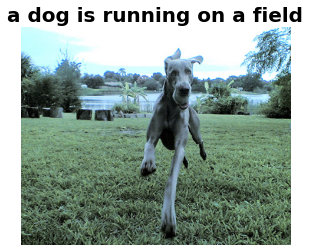

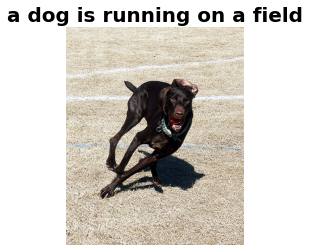

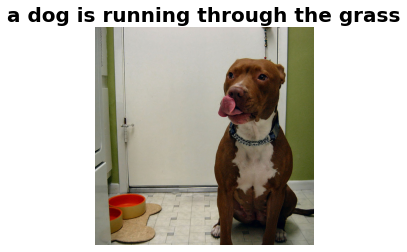

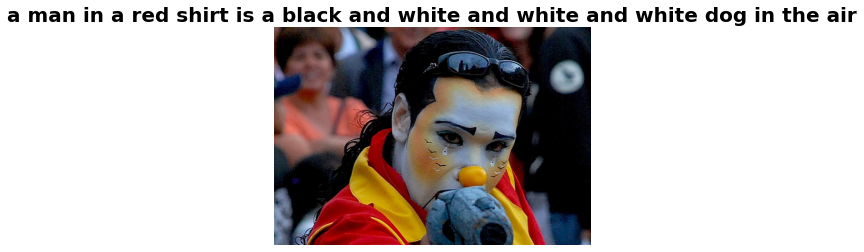

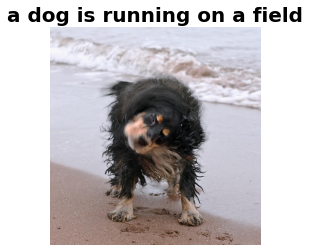

In [52]:
# Predicting subtitles for 5 test images

# Loop through 5 images
for i in range(5):

    # Randomly select an image index
    img = np.random.choice(idx_test)

    # Predict the caption
    caption = predict_caption(img)

    # Plot
    plt.title(caption, fontdict={'fontsize': 20, 'weight': 'bold'})
    image = plt.imread(PATH_IMAGES + img)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print()

# End

Matheus Schmitz

<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a>

<a href="https://matheus-schmitz.github.io/">Github Portfolio</a>

In [8]:
%%shell
jupyter nbconvert --to html Image_Captioning.ipynb

[NbConvertApp] Converting notebook Image_Captioning.ipynb to html
[NbConvertApp] Writing 1650885 bytes to Image_Captioning.html
